In [105]:
import numpy as np
import pandas as pd
import re
import ast
import seaborn as sns
import networkx as nx

# regression / matching
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

In [2]:
# Change the file path for the file movie.metadata.tsv
file_path = "data/movie.metadata.tsv"

In [3]:
# Reading the file into a pandas dataframe
movie_summaries = pd.read_csv(file_path, sep="\t", header=None)
movie_summaries.columns = ["Wikipedia movie ID",
 "Freebase_movie_ID",
 "Movie_name",
 "Movie_release_date",
 "Movie_box_office_revenue",
 "Movie_runtime",
 "Movie_languages",
 "Movie_countries",
 "Movie_genres"]
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
# Remove prefix '/m/'
movie_summaries['Freebase_movie_ID'] = movie_summaries['Freebase_movie_ID'].str.replace('/m/', '')

In [5]:
# Create new columns for languages, countries and genres
# The data type of the new columns is list containing all possible values
# Only take the values into account for now,
# If we need the code for further analysis, just apply x.keys() instead of x.values()

movie_summaries['Movie_languages_clean'] = movie_summaries['Movie_languages'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_countries_clean'] = movie_summaries['Movie_countries'].apply(ast.literal_eval).apply(lambda x: list(x.values()))
movie_summaries['Movie_genres_clean'] = movie_summaries['Movie_genres'].apply(ast.literal_eval).apply(lambda x: list(x.values()))

In [6]:
# Extract the release year
# This column only contains the years
movie_summaries['Movie_release_year'] = movie_summaries['Movie_release_date'].str.extract(r'(\d{4})')

# Convert strings to datetime values if there are
# For the rows with only years, the value is replaced by NaT
# pd.to_datetime has a bug if the format provided is more "precise" than what is in the dataframe, it has default values and will not 
# raise an error or replace with NaT
# specifically %Y-%m-%d with year 2000 defaults to 2000-01-01, even with the exact=True argument.

movie_summaries['Movie_release_date_datetime'] = movie_summaries['Movie_release_date'].astype('str').apply(
        lambda x: pd.to_datetime(x if "-" in x else pd.NaT, errors="coerce")
)

In [7]:
movie_summaries.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT


In [8]:
display(movie_summaries['Movie_release_year'].dropna().max())
display(movie_summaries['Movie_release_year'].dropna().min())

'2016'

'1010'

In [9]:
import requests
from bs4 import BeautifulSoup

In [10]:
def getData(year):
    url = f'https://www.boxofficemojo.com/year/{year}/?sortDir=asc&sort=rank&grossesOption=totalGrosses'

    # Send a GET request to the URL
    response = requests.get(url)

    df = pd.DataFrame()
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the page
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract relevant information (modify this based on the structure of the webpage)
        # Example: Extracting movie titles
        df['movie_title'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-left mojo-field-type-release mojo-cell-wide')]
        df['movie_revenue'] = [title.text.strip() for title in soup.find_all('td', class_='a-text-right mojo-field-type-money mojo-estimatable')]

        
    return df

In [11]:
# Uncomment if you need to re-write the data from the website

# df_all = pd.DataFrame()

# #Python range is not inclusive for the second value
# for i in range(1977, 2024):
#    temp = getData(i)
#    df_all = pd.concat([df_all, temp], ignore_index=True)
  
# #Write to csv
# df_all.to_csv('data/mojo_data.csv', header=None, index=False)

In [12]:
# Reading the file into a pandas dataframe
df_all = pd.read_csv('data/mojo_data.csv', header=None)
df_all.columns = ["movie_title",
 "movie_revenue"]
df_all.head()


,movie_title,movie_revenue
0,Star Wars: Episode IV - A New Hope,"$307,263,857"
1,Smokey and the Bandit,"$126,737,428"
2,Close Encounters of the Third Kind,"$116,395,460"
3,Saturday Night Fever,"$94,213,184"
4,A Bridge Too Far,"$50,750,000"


In [13]:
# We can just always consider the original dataset, and replace the missing revenues with the ones from the Mojo dateset

# Drop duplicate movies, based on name only
df_all = df_all.drop_duplicates(subset=['movie_title'])
movie_summaries = movie_summaries.drop_duplicates(subset=['Movie_name'])
# Merge dataframes based on the movie name, left join so we keep all of the original data
merged_df = pd.merge(movie_summaries, df_all, right_on='movie_title', left_on='Movie_name', how='left')

# Drop the extra column (either 'movie_title' or 'Movie_name') if needed
# merged_df = merged_df.drop('movie_title', axis=1)

# Cleaning up the revenues

# Remove the dollar sign and commas
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(str).str.replace('$', '').str.replace(',', '')

# Convert the column to floats
merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(float)

# Create a boolean mask for rows where movie_revenue is NaN and gross_revenue is not NaN
mask = (pd.isna(merged_df['Movie_box_office_revenue'])) & (~pd.isna(merged_df['movie_revenue']))

# Replace missing values in Movie_box_office_revenue with movie_revenue 
merged_df.loc[mask, 'Movie_box_office_revenue'] = merged_df.loc[mask, 'movie_revenue']



# Tests to make sure it works as intended
# test = merged_df.copy(deep=True)
# test.loc[mask, 'Movie_box_office_revenue'] = test.loc[mask, 'movie_revenue']
# mask = (pd.isna(test['Movie_box_office_revenue'])) & (~pd.isna(test['movie_revenue']))
# result = test[mask]
# print(result.shape)

# print(merged_df[pd.isna(merged_df['Movie_box_office_revenue'])].shape)
# print(test[pd.isna(test['Movie_box_office_revenue'])].shape)

C:\Users\fifko\AppData\Local\Temp\ipykernel_24032\2566794732.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  merged_df['movie_revenue'] = merged_df['movie_revenue'].astype(str).str.replace('$', '').str.replace(',', '')


In [14]:
display(merged_df.loc[merged_df['Movie_name'] == 'Coming to America'])
# There are some differences in revenue in the two datasets, but we just keep the original dataset value in that case


,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime,movie_title,movie_revenue
75441,54540,0f7hw,Coming to America,1988-06-29,288752301.0,117.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/03p5xs"": ""...",[English Language],[United States of America],"[Romantic comedy, Comedy of manners, Drama, Co...",1988,1988-06-29,Coming to America,128152301.0


In [15]:
budget_path= "https://drive.google.com/uc?id=" + "https://drive.google.com/file/d/1P6utrC8Hjxh4HJ3q8GQZwXMOmDmhwFzS/view?usp=sharing".split("/")[-2]

budget = pd.read_csv(
    budget_path, usecols=["id", "budget", "original_title", "release_date", "runtime"]
)

#Conversion to datetime
budget["Movie_release_year"] = pd.to_datetime(
    budget["release_date"], infer_datetime_format=True, errors="coerce"
).dt.year

#renaming for column matching in the merge
budget = budget.rename(
    columns={"original_title": "Movie_name", "runtime": "Movie_runtime"}
)

# converting '\\N' values to np.nan
budget.loc[budget["Movie_release_year"] == "\\N", "Movie_release_year"] = np.nan
budget.loc[budget["Movie_runtime"] == "\\N", "Movie_runtime"] = np.nan

#removing the rows with nan
budget = budget[budget["Movie_release_year"].notna()]

# converting release year to 'int64'
budget["Movie_release_year"] = budget["Movie_release_year"].astype("int64", errors="ignore")

# converting runtime to 'float64'
budget["Movie_runtime"] = budget["Movie_runtime"].astype("float64")

In [16]:
#Merging the budget datafram with the main dataframe
budget["Movie_release_year"] = budget["Movie_release_year"].astype("str")
# merge 'movies' with 'budget'
merged_df = pd.merge(
    left=merged_df,
    right=budget,
    how="left",
    on=["Movie_name", "Movie_release_year", "Movie_runtime"],
)
# convert budget to float
merged_df["budget"] = merged_df["budget"].astype("float")

merged_df.head()

,Wikipedia movie ID,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Movie_languages_clean,Movie_countries_clean,Movie_genres_clean,Movie_release_year,Movie_release_date_datetime,movie_title,movie_revenue,budget,id,release_date
0,975900,03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...",2001,2001-08-24,Ghosts of Mars,8709640.0,28000000.0,10016,2001-08-24
1,3196793,08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]",2000,2000-02-16,NaN,NaN,NaN,NaN,NaN
2,28463795,0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",[Norwegian Language],[Norway],"[Crime Fiction, Drama]",1988,NaT,NaN,NaN,NaN,NaN,NaN
3,9363483,0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...",1987,NaT,NaN,NaN,NaN,NaN,NaN
4,261236,01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",[German Language],[Germany],[Drama],1983,NaT,NaN,NaN,NaN,NaN,NaN


In [17]:
#matching

# # Function to create edges based on budget similarity and genre matching
# def create_edges(df):
#     G = nx.Graph()
    
#     for idx, row in df.iterrows():
#         current_budget = row['budget']
#         current_genres = set(row['Movie_genres'])  # Assuming 'movie_genre' is the column containing lists of genres
#         current_runtime = row['Movie_runtime']
        
#         current_language_count = row['language_count']
#         current_revenue = row['Movie_box_office_revenue']
        
#         for match_idx, match_row in df.iterrows():
#             if match_idx == idx:
#                 continue
            
#             match_budget = match_row['budget']
#             match_genres = set(match_row['Movie_genres'])
#             match_runtime = match_row['Movie_runtime']
            
#             if abs(current_budget - match_budget) / ((current_budget + match_budget) / 2) * 100 < 20 and \
#                 len(current_genres.intersection(match_genres)) > 0 and\
#                 abs(current_runtime - match_runtime) / ((current_runtime + match_runtime) / 2) * 100 < 10:
                    
#                 G.add_edge(idx, match_idx, 
#                            budget_similarity=abs(match_budget - current_budget),
#                            genres_intersection=list(current_genres.intersection(match_genres)),
#                            runtime_similarity=abs(match_runtime - current_runtime),
#                            language_count_1=current_language_count,
#                            language_count_2=match_row['language_count'],
#                            revenue_1=current_revenue,
#                            revenue_2=match_row['Movie_box_office_revenue'])
    
#     return G

# # Create edges based on similarity measures
# df_matched = merged_df.dropna().copy(deep=True)
# df_matched = df_matched[df_matched["budget"] != 0]
# df_matched['language_count'] = df_matched['Movie_languages_clean'].apply(len)
# movie_graph = create_edges(df_matched)

# # Find the maximum weight matching in the graph (using the combination of budget similarity and genre matching)
# matching_edges = nx.max_weight_matching(movie_graph)

# # Get the matched pairs
# matched = [i[0] for i in list(matching_edges)] + [i[1] for i in list(matching_edges)]

# matched_data = df_matched.loc[matched]
# matched_data.to_csv('data/matched_data.csv', header=True, index=False)
# display(matched_data)


In [41]:
matched_data = pd.read_csv("data/matched_data.csv")
merged_df = matched_data.copy(deep=True)
merged_df['Movie_languages_clean'] = merged_df['Movie_languages'].apply(ast.literal_eval).apply(lambda x: list(x.values()))

As expected, the english languages has the highest total box revenue, as most of the movies in our dataset contain english as a language.

The language that makes the most money is English Language with a total revenue of $127,721,656,605.0


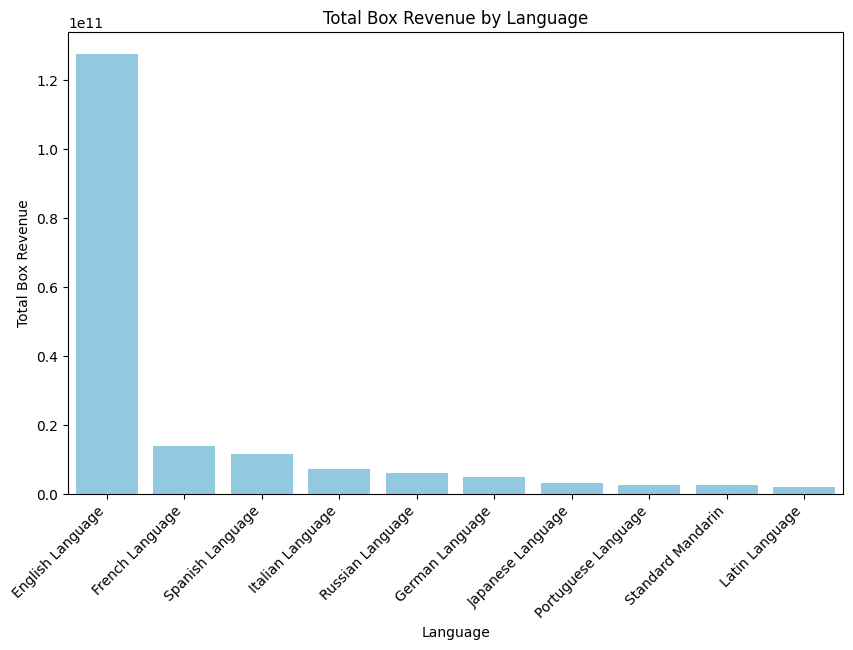

In [133]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')
language_revenue = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].sum().reset_index()
language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(language_revenue.head(10), x='Movie_languages_clean', y='Movie_box_office_revenue', color='skyblue')
plt.xlabel('Language')
plt.ylabel('Total Box Revenue')
plt.title('Total Box Revenue by Language')
plt.xticks(rotation=45, ha='right')

language_revenue = language_revenue.sort_values(by='Movie_box_office_revenue', ascending=False)
top_language = language_revenue.iloc[0]['Movie_languages_clean']
top_revenue = language_revenue.iloc[0]['Movie_box_office_revenue']
print(f"The language that makes the most money is {top_language} with a total revenue of ${top_revenue:,}")

The language used in the most movies is English Language with a total movie count of 1322
The language used in the most movies is Spanish Language with a total movie count of 99


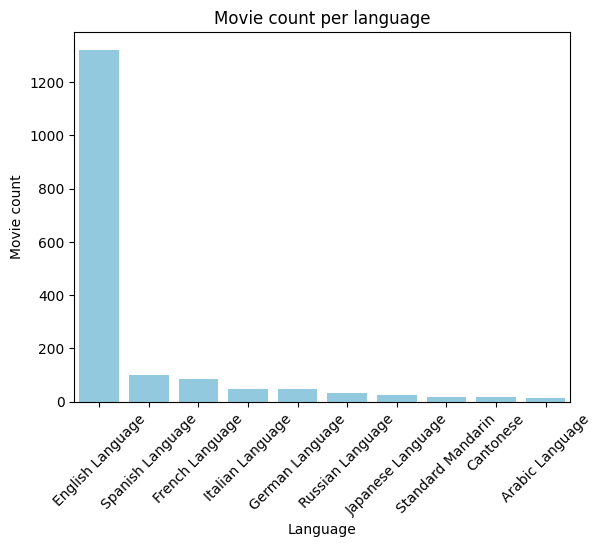

In [138]:
language_revenue = df_language.groupby('Movie_languages_clean').size().reset_index(name='counts')
language_revenue = language_revenue.sort_values(by='counts', ascending=False)
sns.barplot(language_revenue.head(10), x='Movie_languages_clean', y='counts', color='skyblue')
plt.xlabel('Language')
plt.ylabel('Movie count')
plt.title('Movie count per language')
plt.xticks(rotation=45)
print(f"The language used in the most movies is {language_revenue.iloc[0]['Movie_languages_clean']} with a total movie count of {language_revenue.iloc[0]['counts']}")
print(f"The language used in the most movies is {language_revenue.iloc[1]['Movie_languages_clean']} with a total movie count of {language_revenue.iloc[1]['counts']}")

The language with the highest average revenue per movie is Old English language with an average revenue of $561,220,428.00


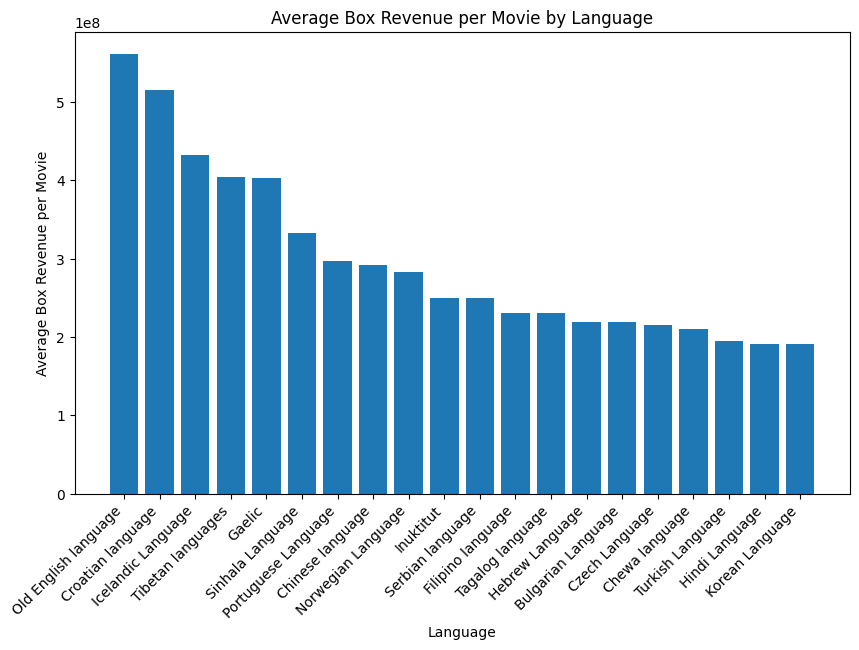

In [139]:
df_language = merged_df[['Freebase_movie_ID', 'Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]
df_language = df_language.explode('Movie_languages_clean')

# Calculate the average revenue per movie for each language
language_stats = df_language.groupby('Movie_languages_clean')['Movie_box_office_revenue'].agg(['sum', 'count'])
language_stats['average_revenue_per_movie'] = language_stats['sum'] / language_stats['count']
language_stats = language_stats.sort_values(by='average_revenue_per_movie', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(language_stats.index[:20], language_stats['average_revenue_per_movie'][:20])
plt.xlabel('Language')
plt.ylabel('Average Box Revenue per Movie')
plt.title('Average Box Revenue per Movie by Language')
plt.xticks(rotation=45, ha='right')


top_language = language_stats.index[0]
top_average_revenue = language_stats['average_revenue_per_movie'].iloc[0]
print(f"The language with the highest average revenue per movie is {top_language} with an average revenue of ${top_average_revenue:,.2f}")



In [140]:
language_stats = language_stats.reset_index()


In [141]:
display(language_stats)

,Movie_languages_clean,sum,count,average_revenue_per_movie
0,Old English language,1.122441e+09,2,5.612204e+08
1,Croatian language,1.030131e+09,2,5.150657e+08
2,Icelandic Language,4.319000e+08,1,4.319000e+08
3,Tibetan languages,8.073934e+08,2,4.036967e+08
4,Gaelic,4.024800e+08,1,4.024800e+08
...,...,...,...,...
75,Yiddish Language,3.358842e+07,3,1.119614e+07
76,Thai Language,1.861501e+07,2,9.307506e+06
77,Gujarati Language,8.049666e+06,1,8.049666e+06
78,Irish,5.080409e+06,1,5.080409e+06


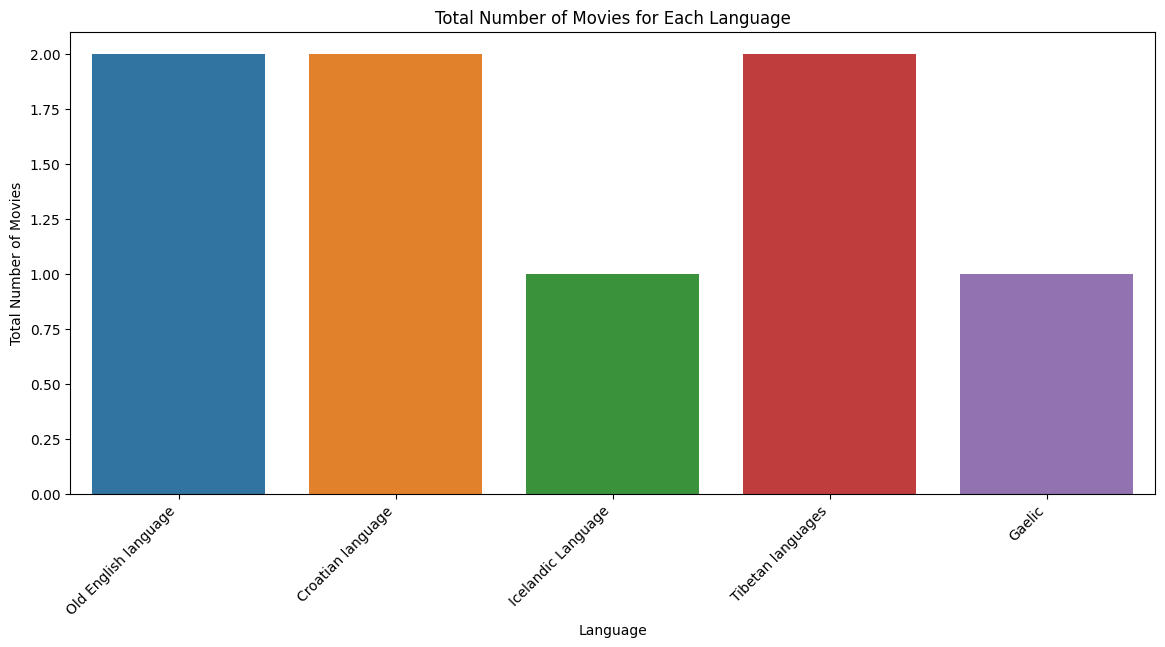

In [142]:


# Plotting the bar chart
plt.figure(figsize=(14, 6))
sns.barplot(language_stats.head(5), x='Movie_languages_clean', y='count')

plt.title('Total Number of Movies for Each Language')
plt.xlabel('Language')
plt.ylabel('Total Number of Movies')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability



plt.show()

A lot of exotic/less known languages have the highest average revenue.\
This could be explained by the fact that exotic languages are only used rarely, in big budget movies, which brings the average revenue up, compared to more common languages that are used in a lot movies, including movies that have low box office revenue.\
\
For example, we can look at the Old English language. The only movies containing these languages are very popular ones with high budgets.

In [143]:
# Movies that used Old English
test = df_language.explode('Movie_languages_clean')
display(test.loc[test['Movie_languages_clean'] == 'Old English language'].iloc[:, 1:])


,Movie_name,Movie_box_office_revenue,Movie_languages_clean
271,Beowulf,196393745.0,Old English language
771,The Lord of the Rings: The Two Towers,926047111.0,Old English language


In [144]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [148]:
df_reg = merged_df[['Movie_name', 'Movie_box_office_revenue', 'Movie_languages_clean']]

# Remove nans
df_reg = df_reg.dropna()
df_reg = df_reg.dropna(axis=1)

df_reg = df_reg.explode('Movie_languages_clean', ignore_index=True)
df_reg = df_reg.dropna(subset=['Movie_languages_clean'])

df_reg['Movie_languages_clean'] = df_reg['Movie_languages_clean'].apply(lambda x: x.encode('utf-8', 'replace').decode('utf-8'))

# The languages are transformed into columns representing 0 or 1 for whether the movie contains the language
df_reg = pd.get_dummies(df_reg, columns=['Movie_languages_clean'], prefix='', prefix_sep='')


# Perform linear regression
X = df_reg.drop(columns=['Movie_name', 'Movie_box_office_revenue'])  # Features = all languages
y = df_reg['Movie_box_office_revenue']  # y = revenue

# Add a constant to the features (required for statsmodels) since we're not using an explicit formula
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

print(model.summary())

                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.069
Model:                                  OLS   Adj. R-squared:                  0.028
Method:                       Least Squares   F-statistic:                     1.687
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):           0.000200
Time:                              15:47:06   Log-Likelihood:                -38201.
No. Observations:                      1886   AIC:                         7.656e+04
Df Residuals:                          1806   BIC:                         7.701e+04
Df Model:                                79                                         
Covariance Type:                  nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

In [151]:
# Extracting coefficients, p-values, and feature names
coefficients = model.params
p_values = model.pvalues
features = model.params.index

# Creating a DataFrame
regression_summary = pd.DataFrame({
    'feature': features,
    'coefficient': coefficients,
    'p_value': p_values
}).reset_index(drop=True)


# Select languages that have a low p-value from the logistic regression
high_sig = regression_summary.loc[regression_summary['p_value'] < 0.05]

# Sort the DataFrame by p-value in ascending order and select the first 3 rows, exluding intercept
lowest_p_values = high_sig.sort_values('p_value')[1:]

# Display the result
display(lowest_p_values)

,feature,coefficient,p_value
52,Old English language,4.255669e+08,0.000096
17,Croatian language,3.794121e+08,0.000503
55,Portuguese Language,1.612976e+08,0.002176
21,English Language,-3.904112e+07,0.003861
71,Tibetan languages,2.680431e+08,0.013900
4,American English,-9.882587e+07,0.039017


TODO update this, results changed

Our r-squared value is close to 0, indicating that the model does not explain almost any variability in the dependent variable.

Most of the languages with the lowest p-value are exotic, i.e. not very commonly usede. This is in line with our previous assumption that exotic languages are associated with high revenue because they are rarely used, and mainly in high-budget movies.

However, it is important to note that this is not sufficient to conclude that these languages have an impact on the revenue of a movie.


In [152]:

# Function to create edges based on budget similarity and genre matching
def create_edges(df, treatment, control):
    G = nx.Graph()
    
    for idx, row in control.iterrows():
        control_budget = row['budget']
        control_genres = set(row['Movie_genres'])  # Assuming 'movie_genre' is the column containing lists of genres
        control_runtime = row['Movie_runtime']
        
        control_language_count = row['language_count']
        control_revenue = row['Movie_box_office_revenue']
        
        for treat_idx, treat_row in treatment.iterrows():
            if treat_idx == idx:
                continue
            
            treat_budget = treat_row['budget']
            treat_genres = set(treat_row['Movie_genres'])
            treat_runtime = treat_row['Movie_runtime']
            
            if abs(control_budget - treat_budget) / ((control_budget + treat_budget) / 2) * 100 < 20 and \
                len(control_genres.intersection(treat_genres)) > 0 and\
                abs(control_runtime - treat_runtime) / ((control_runtime + treat_runtime) / 2) * 100 < 10:
                    
                G.add_edge(idx, treat_idx, 
                           budget_similarity=abs(treat_budget - control_budget),
                           genres_intersection=list(control_genres.intersection(treat_genres)),
                           runtime_similarity=abs(treat_runtime - control_runtime),
                           language_count_1=control_language_count,
                           language_count_2=treat_row['language_count'],
                           revenue_1=control_revenue,
                           revenue_2=treat_row['Movie_box_office_revenue'])
                
    # Find the maximum weight matching in the graph (using the combination of budget similarity and genre matching)
    matching_edges = nx.max_weight_matching(G)

    # Get the matched pairs
    matched = [i[0] for i in list(matching_edges)] + [i[1] for i in list(matching_edges)]    
    
    return df.loc[matched]

In [128]:
df_reg = merged_df.copy(deep=True)

# # Remove nans
# df_reg = df_reg.dropna()
# df_reg = df_reg.dropna(axis=1)

df_reg = df_reg.explode('Movie_languages_clean', ignore_index=True)
df_reg = df_reg.dropna(subset=['Movie_languages_clean'])

df_reg['Movie_languages_clean'] = df_reg['Movie_languages_clean'].apply(lambda x: x.encode('utf-8', 'replace').decode('utf-8'))

# The languages are transformed into columns representing 0 or 1 for whether the movie contains the language
df_reg = pd.get_dummies(df_reg, columns=['Movie_languages_clean'], prefix='', prefix_sep='')

In [127]:
#matching for Old English

treatment_df = df_reg[df_reg['Old English language'] == 1]
control_df = df_reg[df_reg['Old English language'] == 0]

matched_old_english = create_edges(df_reg, treatment_df, control_df)

model_old_english = smf.ols(formula='Movie_box_office_revenue ~  Q("Old English language")', data=matched_old_english).fit()
print("\033[1mModel Matched: Movie_box_office_revenue ~ Old English language\033[0m")
print(model_old_english.summary())

Model Matched: Movie_box_office_revenue ~ Old English language
                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.388
Model:                                  OLS   Adj. R-squared:                  0.082
Method:                       Least Squares   F-statistic:                     1.268
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):              0.377
Time:                              14:26:17   Log-Likelihood:                -83.155
No. Observations:                         4   AIC:                             170.3
Df Residuals:                             2   BIC:                             169.1
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      

C:\Users\fifko\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [129]:
#matching for Croatian

treatment_df = df_reg[df_reg['Croatian language'] == 1]
control_df = df_reg[df_reg['Croatian language'] == 0]

matched_old_croatian = create_edges(df_reg, treatment_df, control_df)

model_old_croatian = smf.ols(formula='Movie_box_office_revenue ~  Q("Croatian language")', data=matched_old_croatian).fit()
print("\033[1mModel Matched: Movie_box_office_revenue ~ Croatian language\033[0m")
print(model_old_croatian.summary())

Model Matched: Movie_box_office_revenue ~ Croatian language
                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.004
Model:                                  OLS   Adj. R-squared:                 -0.494
Method:                       Least Squares   F-statistic:                  0.007843
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):              0.938
Time:                              14:41:17   Log-Likelihood:                -85.138
No. Observations:                         4   AIC:                             174.3
Df Residuals:                             2   BIC:                             173.0
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]

C:\Users\fifko\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [130]:
#matching for Portuguese

treatment_df = df_reg[df_reg['Portuguese Language'] == 1]
control_df = df_reg[df_reg['Portuguese Language'] == 0]

matched_old_portuguese = create_edges(df_reg, treatment_df, control_df)

model_old_portuguese = smf.ols(formula='Movie_box_office_revenue ~  Q("Portuguese Language")', data=matched_old_portuguese).fit()
print("\033[1mModel Matched: Movie_box_office_revenue ~ Portuguese Language\033[0m")
print(model_old_portuguese.summary())

Model Matched: Movie_box_office_revenue ~ Portuguese Language
                               OLS Regression Results                               
Dep. Variable:     Movie_box_office_revenue   R-squared:                       0.044
Model:                                  OLS   Adj. R-squared:                 -0.016
Method:                       Least Squares   F-statistic:                    0.7360
Date:                      Fri, 22 Dec 2023   Prob (F-statistic):              0.404
Time:                              14:41:20   Log-Likelihood:                -375.14
No. Observations:                        18   AIC:                             754.3
Df Residuals:                            16   BIC:                             756.1
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.

C:\Users\fifko\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
